In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
import random
import os
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [14]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

def lg_nrmse(gt, preds):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    all_nrmse = []
    for idx in range(0,14): # ignore 'ID'
        rmse = mean_squared_error(np.array(gt)[:,idx], preds[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(np.array(gt)[:,idx]))
        all_nrmse.append(nrmse)
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:15])
    return score, all_nrmse

In [4]:
import time
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from collections import defaultdict

train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LG/train.csv').drop(columns="ID")

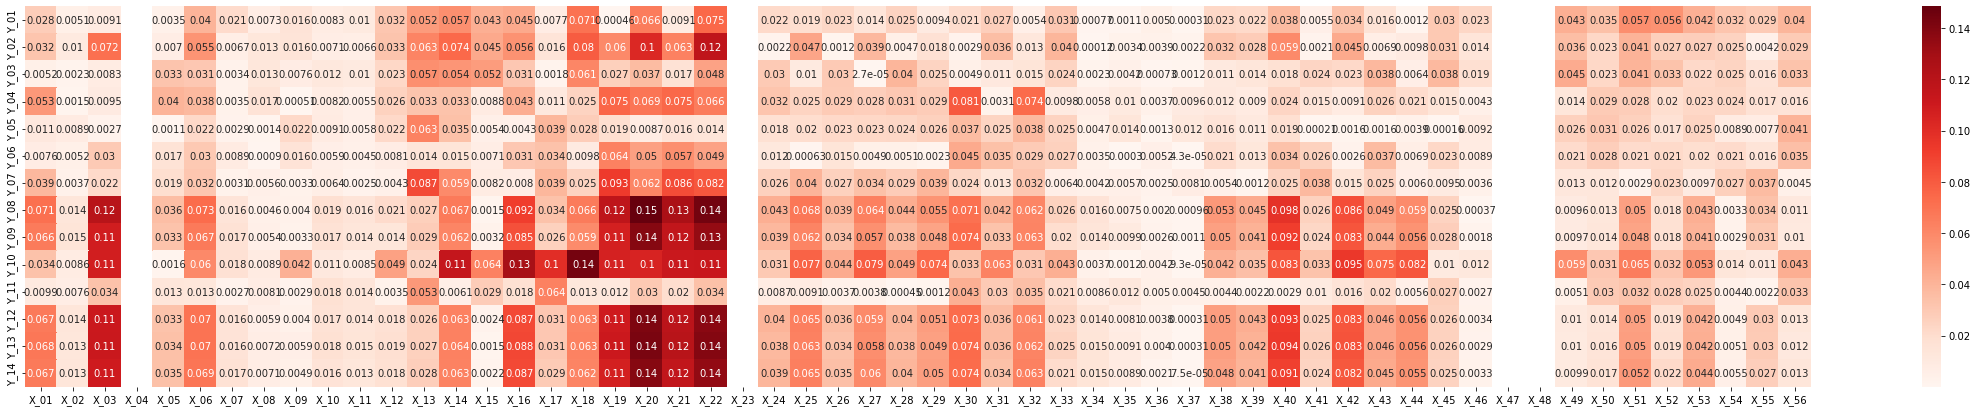

In [5]:
cor_pass = train_df.corr(method='pearson')
cor_pass = xycor_pass = cor_pass.filter(regex='X').filter(regex='Y', axis=0)

plt.rcParams["figure.figsize"] = (40,7)
sns.heatmap(xycor_pass.abs(),
           annot = True, #실제 값 화면에 나타내기
           cmap = 'Reds', #색상
          )

In [7]:
# 사용할 변수들
columns = [ 'X_01', 'X_03', 'X_05', 'X_06', 'X_07', 'X_08', 'X_09', 'X_10'
          , 'X_11', 'X_14', 'X_15', 'X_16', 'X_17', 'X_18', 'X_19', 'X_20'
          , 'X_22', 'X_26', 'X_28', 'X_29', 'X_31', 'X_32', 'X_33', 'X_38'
          , 'X_42', 'X_44', 'X_45', 'X_46', 'X_49']

In [8]:
train_x = train_df.filter(items=columns) # Input : X Featrue
train_y = train_df.filter(regex='Y') # Output : Y Feature

train_x

,X_01,X_03,X_05,X_06,X_07,X_08,X_09,X_10,X_11,X_14,...,X_29,X_31,X_32,X_33,X_38,X_42,X_44,X_45,X_46,X_49
0,70.544,67.47,101.892,74.983,29.45,62.38,245.71,0.0,0.0,13.34,...,2.35,1.69,1.46,1.74,-16.41,20.99,21.09,0.29,1463,9706.03
1,69.524,65.17,101.944,72.943,28.73,61.23,233.61,0.0,0.0,13.33,...,2.28,1.67,1.45,1.66,-16.06,21.03,21.13,0.13,1463,10423.43
2,72.583,64.07,103.153,72.943,28.81,105.77,272.20,0.0,0.0,13.36,...,2.26,1.69,1.46,1.68,-16.16,21.03,21.12,0.14,1468,10948.53
3,71.563,67.57,101.971,77.022,28.92,115.21,255.36,0.0,0.0,13.30,...,2.12,1.68,1.47,1.68,-16.05,20.98,21.09,0.22,1469,15007.03
4,69.524,63.57,101.981,70.904,29.68,103.38,241.46,0.0,0.0,13.35,...,2.13,1.68,1.47,1.82,-16.25,20.96,21.10,0.22,1469,11051.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39602,66.465,62.27,103.150,66.825,30.20,77.83,298.05,0.0,0.0,13.37,...,2.20,1.60,1.36,1.67,-16.09,21.08,21.19,0.11,1469,60630.73
39603,66.465,62.77,102.021,66.825,29.21,102.25,270.67,0.0,0.0,13.36,...,2.20,1.68,1.37,1.77,-15.70,21.09,21.19,0.12,1458,60763.43
39604,68.504,64.67,103.144,68.864,29.96,102.61,198.07,0.0,0.0,13.38,...,2.16,1.61,1.37,1.58,-16.12,21.09,21.19,0.13,1459,8813.33
39605,66.465,63.67,102.025,67.845,30.30,112.60,275.52,0.0,0.0,13.36,...,2.12,1.56,1.36,1.67,-16.36,21.05,21.13,0.11,1469,62222.33


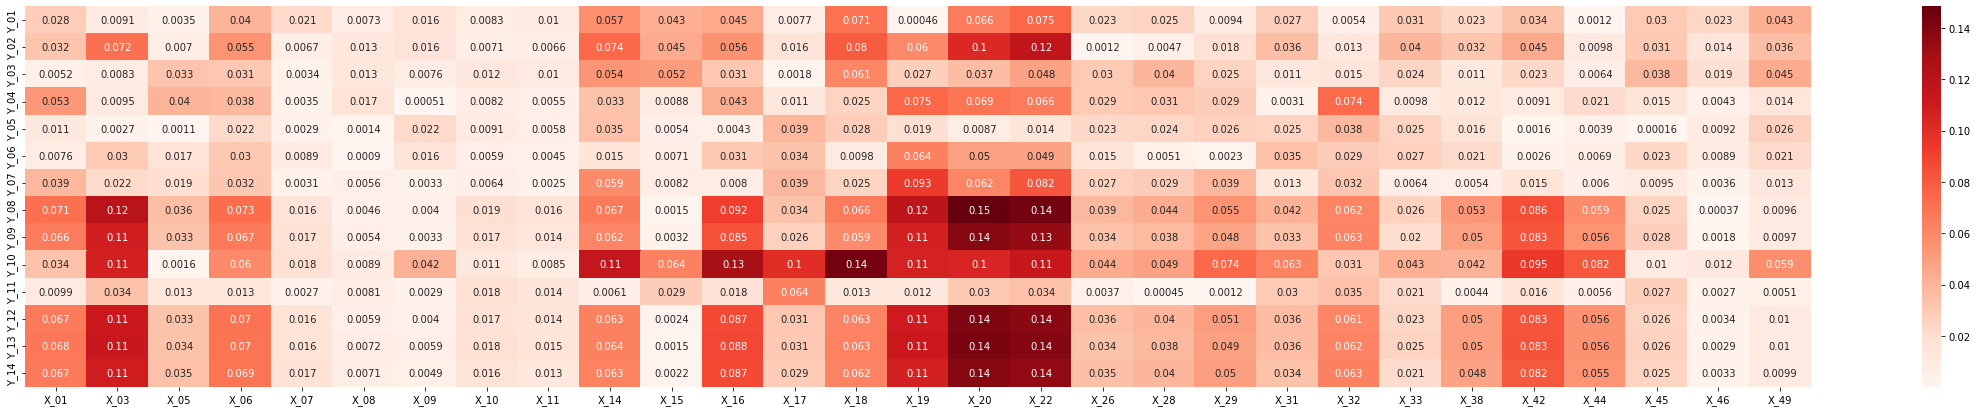

In [9]:
cor_pass = train_df.corr(method='pearson')
cor_pass = xycor_pass = cor_pass.filter(items=columns).filter(regex='Y', axis=0)

plt.rcParams["figure.figsize"] = (40,7)
sns.heatmap(xycor_pass.abs(),
           annot = True, #실제 값 화면에 나타내기
           cmap = 'Reds', #색상
          )

In [16]:
# RF
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.3, random_state=10)

model = make_pipeline( 
  RandomForestRegressor(random_state=10, n_jobs=-1
                      , n_estimators=400
                      , max_depth=80
                      , min_samples_leaf=2
                      , min_samples_split=2)
)


model.fit(x_train, y_train)

y_predict = model.predict(x_test)

In [17]:
lg_score = lg_nrmse(y_test, y_predict)
print('NRMSE :', lg_score)

NRMSE : (1.9617686624057902, [0.25831184451556183, 0.3565922746711553, 0.35198919673743284, 0.1874217691591839, 0.0791762820371195, 0.10926728820831748, 0.1282306873298429, 0.023957001079406893, 0.02379920787424535, 0.03880638551034705, 0.033505287200680016, 0.023931570632784727, 0.023867307088693224, 0.023923291613415307])


In [ ]:
test_x = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LG/test.csv').drop(columns=['ID'])
test_x = test_x.filter(items=columns)
test_x

,X_01,X_03,X_05,X_06,X_07,X_08,X_09,X_10,X_11,X_14,...,X_29,X_31,X_32,X_33,X_38,X_42,X_44,X_45,X_46,X_49
0,68.504,76.67,101.867,73.963,30.51,63.57,239.80,0.0,0.0,13.38,...,2.22,1.53,1.33,1.53,-16.17,21.06,21.20,0.16,1469,17227.63
1,67.485,69.37,101.992,67.845,28.03,116.99,189.23,0.0,0.0,13.35,...,2.20,1.56,1.34,1.55,-15.35,20.99,21.15,0.27,1462,17134.53
2,69.524,68.97,101.884,77.022,29.65,205.68,214.93,0.0,0.0,13.32,...,2.26,1.69,1.47,1.71,-16.27,21.05,21.19,0.14,1469,14860.83
3,69.524,65.87,101.866,73.963,28.15,103.38,180.80,0.0,0.0,13.32,...,2.18,1.65,1.46,1.90,-16.06,21.03,21.14,0.13,1469,15252.53
4,73.603,66.67,101.891,74.983,29.92,71.20,231.93,0.0,0.0,13.38,...,2.18,1.73,1.46,1.67,-16.06,21.08,21.17,0.09,1469,10752.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39603,68.504,63.97,103.157,68.864,29.49,116.35,284.16,0.0,0.0,13.38,...,2.16,1.66,1.36,1.56,-16.17,21.13,21.19,0.11,1469,62123.53
39604,68.504,61.37,103.137,68.864,32.29,116.28,272.41,0.0,0.0,13.37,...,2.14,1.64,1.36,1.68,-16.11,21.03,21.12,0.19,1469,61844.13
39605,69.524,63.67,103.149,69.884,30.00,113.05,295.54,0.0,0.0,13.36,...,2.18,1.62,1.35,1.72,-16.23,21.11,21.17,0.12,1469,60277.53
39606,67.485,61.77,103.148,67.845,32.05,115.05,267.26,0.0,0.0,13.38,...,2.20,1.56,1.37,1.59,-15.99,21.10,21.19,0.11,1469,60236.73


In [ ]:
from sklearn.pipeline import make_pipeline

LR = make_pipeline( 
  RandomForestRegressor(criterion="squared_error"
                      , random_state=10, n_jobs=-1
                      , n_estimators=400
                      , max_depth=80
                      , min_samples_leaf=2
                      , min_samples_split=2)
)

LR.fit(train_x, train_y)

preds = LR.predict(test_x)

submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LG/sample_submission.csv')

for idx, col in enumerate(submit.columns):
    if col=='ID':
        continue
    submit[col] = preds[:,idx-1]
print('Done.')

submit.to_csv('/content/drive/MyDrive/Colab Notebooks/LG/submit.csv', index=False)

Done.
